This file contains the code used for implementing the classifer in paper Classification of Acute Leukemia Based on DNA  Microarray gene expressions using partial least squares.

**Data Set**: Merge the train and test data in the original paper and split the merged data 1:1 to form train and test during learning.
    - Merge Data: 72 samples(47 ALL, 25 AML, 62 bone marrow, 10 peripheral blood samples)
    - Train Data: 38 bone marrow samples(27ALL, 11AML).
    - Test Data: 34 samples(24 bone marrow, 10 peripheral blood samples, 20ALL, 14AML).
    - Predictors: 7129 gene expression levels represent 6817 genes.
    
**Main Purpose**: Logistic discrimination(LD), quadratic discriminant analysis(QDA) .

## Reproduce using R

### Step 1 Load and transform dataset. 
Install Bioconductor biocLite package in order to access the golubEsets library. [golubEsets](https://bioconductor.org/packages/release/data/experiment/manuals/golubEsets/man/golubEsets.pdf) contains the raw data used by Todd Golub in the original paper.

We use the scale method in the original paper instead of the thresholding algorithm in this paper for now.

In [1]:
## Most code is commented in this cell since it is unnecessary and time-consuming to run it everytime.
# options(repos='http://cran.rstudio.com/') 
# source("http://bioconductor.org/biocLite.R")
# biocLite("golubEsets")
suppressMessages(library(golubEsets))
#Training data predictor and response

data(Golub_Train)
golub_train_p = t(exprs(Golub_Train))
golub_train_r =pData(Golub_Train)[, "ALL.AML"]
#Testing data predictor
data(Golub_Test)
golub_test_p = t(exprs(Golub_Test))
golub_test_r = pData(Golub_Test)[, "ALL.AML"]

# Thresholding
golub_train_pp = golub_train_p
golub_train_pp[golub_train_pp<100] = 100
golub_train_pp[golub_train_pp>16000] = 16000

# Filtering
golub_filter = function(x, r = 5, d=500){
    minval = min(x)
    maxval = max(x)
    (maxval/minval>r)&&(maxval-minval>d)
}
index = apply(golub_train_pp, 2, golub_filter)
golub_index = (1:7129)[index]
golub_train_pp = golub_train_pp[, golub_index]

golub_test_pp = golub_test_p
golub_test_pp[golub_test_pp<100] = 100
golub_test_pp[golub_test_pp>16000] = 16000
golub_test_pp = golub_test_pp[, golub_index]

# Log Transformation
golub_train_p_trans = log10(golub_train_pp)
golub_test_p_trans = log10(golub_test_pp)

# Normalization
train_m = colMeans(golub_train_p_trans)
train_sd = apply(golub_train_p_trans, 2, sd)
golub_train_p_trans = t((t(golub_train_p_trans)-train_m)/train_sd)
golub_test_p_trans  = t((t(golub_test_p_trans)-train_m)/train_sd)
set.seed(201703)

### Step 2 Feature selection using PCA and PLS

We use the package of 'ropls' in bioconductor.

**_Step 2(a)_**: Select the same 50 genes as in Golub paper. See details in Paper1 notebook.

In [2]:
# Neighbourhood analysis
get_p = function(train_d, train_r){
    tr_m_aml =  colMeans(train_d[train_r == "AML",])
    tr_sd_aml = apply(train_d[train_r == "AML",], 2, sd)
    tr_m_all = colMeans(train_d[train_r == "ALL",])
    tr_sd_all = apply(train_d[train_r == "ALL",], 2, sd)
    p = (tr_m_aml-tr_m_all)/(tr_sd_aml+tr_sd_all)
}
nna = matrix(0, 400, 3051)
# Permutation test
for(i in 1:400){
    t_r = sample(golub_train_r)
    nna[i, ] = get_p(golub_train_p_trans, t_r)
}

# Predictor selection based on the result of Neighbourhood analysis
nna_q = apply(nna, 2, quantile, prob = c(0.005, 0.995))
p = get_p(golub_train_p_trans, golub_train_r)

# With 0.01 significant level
index_1 = (1:3051)[p>=nna_q[2,] | p<=nna_q[1,]]
golub_train_p_trans = golub_train_p_trans[, index_1]
train_m_aml = colMeans(golub_train_p_trans[golub_train_r == "AML",])
train_m_all = colMeans(golub_train_p_trans[golub_train_r =="ALL",])
golub_test_p_trans =golub_test_p_trans[, index_1]
p = p[index_1]
cl_index = c(head(order(p), 25), head(order(p, decreasing = T), 25))
p_50 = p[cl_index]
b = (train_m_aml[cl_index]+train_m_all[cl_index])/2
train_cl = golub_train_p_trans[, cl_index]
test_cl = golub_test_p_trans[, cl_index]

In [3]:
##Run the commented code below if you haven't run it before
#options(repos='http://cran.rstudio.com/') 
#source("http://bioconductor.org/biocLite.R")
#install.packages("caret")
#biocLite("ropls")
library(ropls)
library(MASS)
suppressMessages(library(caret))
gene50_pred = rbind(train_cl, test_cl)
gene50_resp = factor(c(as.character(golub_train_r), as.character(golub_test_r)))

**_Step 2(b)_**: Build classifier based on the train data and do LOOCV and test accuracy.

- Components(K = 3) construction based on traning data(n = 38) by PCA and PLS

In [4]:
# Number of predictors as recommended in the paper
K = 3
#PCA selection
pca_slt = getLoadingMN(opls(train_cl, printL = F, predI = K))
#PLS selection
pls_slt = getLoadingMN(opls(train_cl, golub_train_r, printL = F, predI = K))
rbind(PCA = dim(pca_slt), PLS  = dim(pls_slt))

PCA,50,3
PLS,50,3


- Logistic discrimination and quadratic discriminant analysis

We use caret package to perform model building and LOOCV.

_(1)_: PCA

In [5]:
options(warn=-1)
pca_train_s = t(t(pca_slt)%*%t(train_cl))
pca_test_s = t(t(pca_slt)%*%t(test_cl))
pca_train = data.frame(response = golub_train_r, pca_train_s)
# Logistic Discrimination
pca_ld_s = train(response~., data = pca_train, method = "glm", family = "binomial", trControl = trainControl(method = "LOOCV"))
pca_ld_te = predict(pca_ld_s, data.frame(pca_test_s))
pca_ld_ac = mean(pca_ld_te == golub_test_r)
pca_ld_re = c(LOOCV = pca_ld_s$results$Accuracy, Test = pca_ld_ac)
# QDA
pca_qda_s = train(response~., data = pca_train, method = "qda", trControl = trainControl(method = "LOOCV"))
pca_qda_te = predict(pca_qda_s, data.frame(pca_test_s))
pca_qda_ac = mean(pca_qda_te == golub_test_r)
pca_qda_re = c(LOOCV = pca_qda_s$results$Accuracy, Test = pca_qda_ac)

_Note_ As we can see from below plots, component p1 perfect separate the train data.

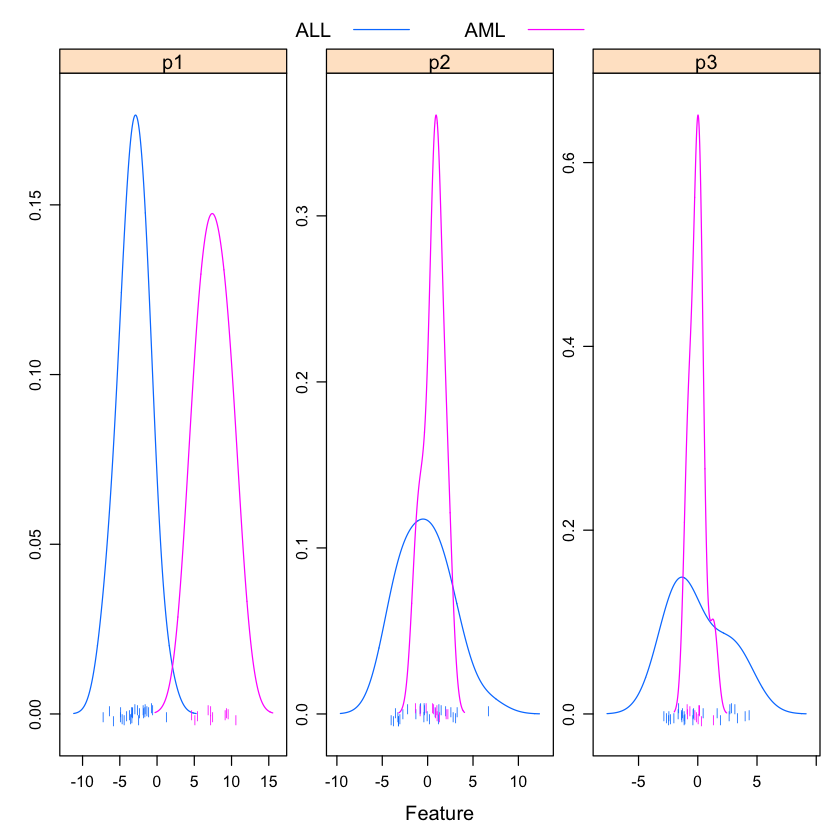

In [6]:
featurePlot(x =data.frame(pca_train_s), 
            y =golub_train_r ,
            plot = "density", 
            scales = list(x = list(relation = "free"), 
                          y = list(relation = "free")), 
            adjust = 1.5, 
            pch = "|", 
            layout = c(3, 1), 
            auto.key = list(columns = 2))

_(2)_: PLS

In [7]:
pls_train_s = t(t(pls_slt)%*%t(train_cl))
pls_test_s = t(t(pls_slt)%*%t(test_cl))
pls_train = data.frame(response = golub_train_r, pls_train_s)
# Logistic discrimination
pls_ld_s = train(response~., data = pls_train, method = "glm", family = "binomial", trControl = trainControl(method = "LOOCV"))
pls_ld_te = predict(pls_ld_s, data.frame(pls_test_s))
pls_ld_ac = mean(pls_ld_te == golub_test_r)
pls_ld_re = c(LOOCV = pls_ld_s$results$Accuracy, Test = pls_ld_ac)
# QDA
pls_qda_s = train(response~., data = pls_train, method = "qda", trControl = trainControl(method = "LOOCV"))
pls_qda_te = predict(pls_qda_s, data.frame(pls_test_s))
pls_qda_ac = mean(pls_qda_te == golub_test_r)
pls_qda_re = c(LOOCV = pls_qda_s$results$Accuracy, Test = pls_qda_ac) 

In [8]:
# show result for step2(b)
rbind(PCA_LD = pca_ld_re, PCA_QDA = pca_qda_re, PLS_LD = pls_qda_re, PLS_QDA = pls_qda_re)
c(PCA_LD = which(pca_ld_te != golub_test_r), PCA_QDA = which(pca_qda_te != golub_test_r), PLS_LD =which(pls_ld_te != golub_test_r), PLS_QDA = which(pls_qda_te != golub_test_r))

,LOOCV,Test
PCA_LD,1,0.9705882
PCA_QDA,1,0.9411765
PLS_LD,1,0.9705882
PLS_QDA,1,0.9705882


PCA_LD PCA_QDA1 PCA_QDA2   PLS_LD  PLS_QDA 
      31       28       31       31       31

In [9]:
pca_test = data.frame(response = golub_test_r, pca_test_s)
pls_test = data.frame(response = golub_test_r, pls_test_s)
save(pca_train, pca_test, pls_train, pls_test, file = "paper6.rda")

**_Step 2(c)_**: Re-randomization for comparison

- 50 randomizations based on the 50 gene data for all combination of feature selection and classification methods.

In [10]:
R = 50
rd_re = matrix(0, 50, 8)
for(i in 1:R){
    # data split
    id = sample(72, 36)
    rd_train_p = gene50_pred[id,]
    rd_train_r = gene50_resp[id]
    rd_test_p = gene50_pred[-id,]
    rd_test_r = gene50_resp[-id]
    #PCA selection
    pca_sl = getLoadingMN(opls(rd_train_p, printL = F,plotL = F, predI = K))
    #PLS selection
    pls_sl = getLoadingMN(opls(rd_train_p, rd_train_r, printL = F, plotL = F, predI = K))
    ##PCA
    pca_train = t(t(pca_sl)%*%t(rd_train_p))
    pca_test = t(t(pca_sl)%*%t(rd_test_p))
    pls_train = t(t(pls_sl)%*%t(rd_train_p))
    pls_test = t(t(pls_sl)%*%t(rd_test_p))
    pca_tr = data.frame(response = rd_train_r, pca_train)
    # Logistic Discrimination
    pca_ld = train(response~., data = pca_tr, method = "glm", family = "binomial", trControl = trainControl(method = "LOOCV"))
    pca_ld_te = predict(pca_ld_s, data.frame(pca_test))
    pca_ld_ac = mean(pca_ld_te == rd_test_r)
    rd_re[i, c(1,2)] = c(LOOCV = pca_ld$results$Accuracy, Test = pca_ld_ac)
    # QDA
    pca_qda = train(response~., data = pca_tr, method = "qda", trControl = trainControl(method = "LOOCV"))
    pca_qda_te = predict(pca_qda, data.frame(pca_test))
    pca_qda_ac = mean(pca_qda_te == rd_test_r)
    rd_re[i, c(3,4)] = c(LOOCV = pca_qda$results$Accuracy, Test = pca_qda_ac)
    
    ## PLS
    pls_tr = data.frame(response = rd_train_r, pls_train)
    # Logistic discrimination
    pls_ld = train(response~., data = pls_tr, method = "glm", family = "binomial", trControl = trainControl(method = "LOOCV"))
    pls_ld_te = predict(pls_ld, data.frame(pls_test))
    pls_ld_ac = mean(pls_ld_te == rd_test_r)
    rd_re[i, c(5,6)] = c(LOOCV = pls_ld$results$Accuracy, Test = pls_ld_ac)
    # QDA
    pls_qda = train(response~., data = pls_tr, method = "qda", trControl = trainControl(method = "LOOCV"))
    pls_qda_te = predict(pls_qda, data.frame(pls_test))
    pls_qda_ac = mean(pls_qda_te == rd_test_r)
    rd_re[i, c(7,8)] = c(LOOCV = pls_qda$results$Accuracy, Test = pls_qda_ac) 
}

In [11]:
options(warn = 0)
result = colMeans(rd_re)
sum_re = rbind(PCA_LD = rd_re[c(1,2)], PCA_QDA = rd_re[c(3,4)], PLS_LD = rd_re[c(5,6)], PLS_QDA = rd_re[c(7,8)])
colnames(sum_re) = c("LOOCV", "Test")
sum_re

,LOOCV,Test
PCA_LD,0.9722222,1.0000000
PCA_QDA,0.9166667,0.9722222
PLS_LD,0.9166667,0.9444444
PLS_QDA,1.0000000,0.9444444


||LOOCV|Test|
|-------|-------|--------|
|PCA_LD|0.9644|0.9417|
|PCA_QDA|0.9700|0.9544|
|PLS_LD|0.9956|0.9594|
|PLS_QDA|0.9956|0.9644|

## Summary of Reproduce result

In step 1, the rescale method in Golub paper is used instead of the thresholding algorithm introduced in the paper. In step 2(a), 50 genes are selected based on the 38 train data and used through the reproduce. As the seed may not be the same, we may not select the same genes as in golub paper, but we definitely select the same genes as in Paper1 notebook. In step 2(b) and (c), caret package and ropls package are used and this one of the reasons that our results are a little different from the paper. However, most of the reproduce follows exactly the algorithms in the paper.

**Result Comparison**:
We have better result in the simple model building experiment. Sample 69 is a tough one for us, which is not the case in the paper. However, we have higher accuracy for most methods. 
As see from the last two table, we have a different result in general compare to the result in the paper for re-randomization part. This may due to we most use modern packages(caret). But I think more and more people will utilize existing package instead of reimplement everything again themselves.

Below are several possible reasons for the difference between results:
1. seed setting and random process
2. using packages for PCA, PLS,LOOCV, LD and QDA.
3. diffferent scale algorithm